In [1]:
import glob
import logging
import os
from pathlib import Path
import shutil
import sys
import tempfile

import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.data import ArrayDataset, create_test_image_3d, decollate_batch, DataLoader
from monai.handlers import (
    MeanDice,
    MLFlowHandler,
    StatsHandler,
    TensorBoardImageHandler,
    TensorBoardStatsHandler,
)
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandSpatialCrop,
    Resize,
    ScaleIntensity,
)
from monai.utils import first

import ignite
import torch

print_config()

/home/douglas.ta/AIS/med/lib64/python3.11/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /home/<username>/AIS/med/lib64/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.14.1
Pillow version: 10.4.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.16.2
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the op

### Data Preparation

In [2]:
### setting up the root and data paths
root_dir = os.getcwd()
data_dir = os.path.join("/home/douglas.ta/LD_ZNet_Replicate/", "UNet", "Latent-Diffusion-Segmentation", "data")

root_dir, data_dir

('/home/douglas.ta/AIS/Latent-Diffusion-Segmentation',
 '/home/douglas.ta/LD_ZNet_Replicate/UNet/Latent-Diffusion-Segmentation/data')

In [3]:
### collecting the datapaths for the volume and segmentation images
images = sorted(glob.glob(os.path.join(data_dir, "volume-*.nii")))
segs = sorted(glob.glob(os.path.join(data_dir, "segmentation-*.nii")))

len(images), len(segs)

(27, 27)

In [4]:
### Define transforms for image and segmentation
imtrans = Compose(
    [
        LoadImage(image_only=True),
        ScaleIntensity(),
        EnsureChannelFirst(),
        RandSpatialCrop((96,96,96), random_size=False),
    ]
)
segtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        RandSpatialCrop((96,96,96), random_size=False),
    ]
)

### Define nifti dataset, dataloader
ds = ArrayDataset(images, imtrans, segs, segtrans)
loader = DataLoader(ds, batch_size=3, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg = first(loader)
print(im.shape, seg.shape)

torch.Size([3, 1, 96, 96, 96]) torch.Size([3, 1, 96, 96, 96])


In [12]:
import nibabel as nib

# loading in example image of data
ex = nib.load(images[0])
print(ex.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 123   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.00000e+00  6.75781e-01  6.75781e-01  5.00000e+00  0.00000e+00
  1.00000e+00  1.00000e+00  5.09990e+04]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : b'TE=0;sec=50999.0000;name='
aux_file        : b'!56THORAXABDOMENvenoespr'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d  

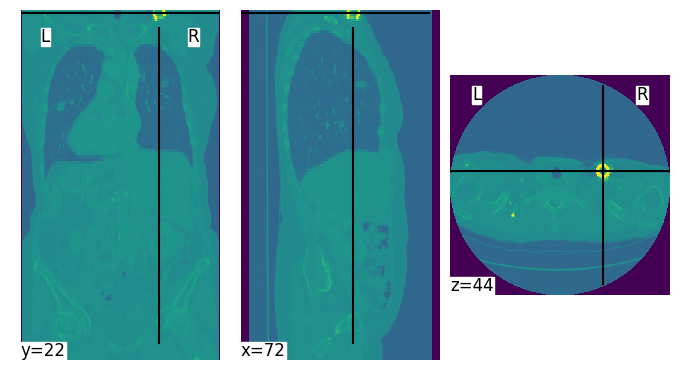

In [13]:
from nilearn import plotting
import matplotlib.pyplot as plt

# displaying an example image of my data
plotting.plot_img(ex)
plt.show()

In [ ]:
# Create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss = DiceLoss(sigmoid=True)
lr = 0.1
opt = torch.optim.Adam(net.parameters(), lr)

In [ ]:
# Create trainer
trainer = ignite.engine.create_supervised_trainer(net, opt, loss, device, False)

In [ ]:
# optional section for checkpoint and tensorboard logging
# adding checkpoint handler to save models (network
# params and optimizer stats) during training
log_dir = os.path.join(root_dir, "logs")
checkpoint_handler = ignite.handlers.ModelCheckpoint(log_dir, "net", n_saved=10, require_empty=False)
trainer.add_event_handler(
    event_name=ignite.engine.Events.EPOCH_COMPLETED,
    handler=checkpoint_handler,
    to_save={"net": net, "opt": opt},
)

# StatsHandler prints loss at every iteration
# user can also customize print functions and can use output_transform to convert
# engine.state.output if it's not a loss value
train_stats_handler = StatsHandler(name="trainer", output_transform=lambda x: x)
train_stats_handler.attach(trainer)

# TensorBoardStatsHandler plots loss at every iteration
train_tensorboard_stats_handler = TensorBoardStatsHandler(log_dir=log_dir, output_transform=lambda x: x)
train_tensorboard_stats_handler.attach(trainer)

# MLFlowHandler plots loss at every iteration on MLFlow web UI
mlflow_dir = os.path.join(log_dir, "mlruns")
train_mlflow_handler = MLFlowHandler(tracking_uri=Path(mlflow_dir).as_uri(), output_transform=lambda x: x)
train_mlflow_handler.attach(trainer)

In [ ]:
# optional section for model validation during training
validation_every_n_epochs = 4
# Set parameters for validation
metric_name = "Mean_Dice"
# add evaluation metric to the evaluator engine
val_metrics = {metric_name: MeanDice()}
post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
post_label = Compose([AsDiscrete(threshold=0.5)])
# Ignite evaluator expects batch=(img, seg) and
# returns output=(y_pred, y) at every iteration,
# user can add output_transform to return other values
evaluator = ignite.engine.create_supervised_evaluator(
    net,
    val_metrics,
    device,
    True,
    output_transform=lambda x, y, y_pred: (
        [post_pred(i) for i in decollate_batch(y_pred)],
        [post_label(i) for i in decollate_batch(y)],
    ),
)

# create a validation data loader
val_imtrans = Compose(
    [
        LoadImage(image_only=True),
        ScaleIntensity(),
        EnsureChannelFirst(),
        Resize((96, 96, 96)),
    ]
)
val_segtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        Resize((96, 96, 96)),
    ]
)
val_ds = ArrayDataset(images[15:], val_imtrans, segs[15:], val_segtrans)
val_loader = DataLoader(val_ds, batch_size=3, num_workers=8, pin_memory=torch.cuda.is_available())


@trainer.on(ignite.engine.Events.EPOCH_COMPLETED(every=validation_every_n_epochs))
def run_validation(engine):
    evaluator.run(val_loader)


# Add stats event handler to print validation stats via evaluator
val_stats_handler = StatsHandler(
    name="evaluator",
    # no need to print loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_stats_handler.attach(evaluator)

# add handler to record metrics to TensorBoard at every validation epoch
val_tensorboard_stats_handler = TensorBoardStatsHandler(
    log_dir=log_dir,
    # no need to plot loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_tensorboard_stats_handler.attach(evaluator)

# add handler to record metrics to MLFlow at every validation epoch
val_mlflow_handler = MLFlowHandler(
    tracking_uri=Path(mlflow_dir).as_uri(),
    # no need to plot loss value, so disable per iteration output
    output_transform=lambda x: None,
    # fetch global epoch number from trainer
    global_epoch_transform=lambda x: trainer.state.epoch,
)
val_mlflow_handler.attach(evaluator)

# add handler to draw the first image and the corresponding
# label and model output in the last batch
# here we draw the 3D output as GIF format along Depth
# axis, at every validation epoch
val_tensorboard_image_handler = TensorBoardImageHandler(
    log_dir=log_dir,
    batch_transform=lambda batch: (batch[0], batch[1]),
    output_transform=lambda output: output[0],
    global_iter_transform=lambda x: trainer.state.epoch,
)
evaluator.add_event_handler(
    event_name=ignite.engine.Events.EPOCH_COMPLETED,
    handler=val_tensorboard_image_handler,
)

In [ ]:
# create a training data loader
train_ds = ArrayDataset(images[:15], imtrans, segs[:15], segtrans)
train_loader = DataLoader(
    train_ds,
    batch_size=3,
    shuffle=True,
    num_workers=8,
    pin_memory=torch.cuda.is_available(),
)

max_epochs = 20
state = trainer.run(train_loader, max_epochs)

2024-10-06 18:50:48,541 - INFO - Epoch: 1/20, Iter: 1/5 -- Loss: 0.9749 
2024-10-06 18:50:48,574 - INFO - Epoch: 1/20, Iter: 2/5 -- Loss: 1.0000 
2024-10-06 18:51:18,197 - INFO - Epoch: 1/20, Iter: 3/5 -- Loss: 0.8092 
2024-10-06 18:51:18,229 - INFO - Epoch: 1/20, Iter: 4/5 -- Loss: 0.8711 
2024-10-06 18:51:18,260 - INFO - Epoch: 1/20, Iter: 5/5 -- Loss: 1.0000 
2024-10-06 18:53:10,579 - INFO - Epoch: 2/20, Iter: 1/5 -- Loss: 1.0000 
2024-10-06 18:53:29,445 - INFO - Epoch: 2/20, Iter: 2/5 -- Loss: 0.7609 
2024-10-06 18:53:29,480 - INFO - Epoch: 2/20, Iter: 3/5 -- Loss: 0.8139 
2024-10-06 18:53:29,513 - INFO - Epoch: 2/20, Iter: 4/5 -- Loss: 1.0000 
2024-10-06 18:53:29,545 - INFO - Epoch: 2/20, Iter: 5/5 -- Loss: 0.9139 
2024-10-06 18:55:19,253 - INFO - Epoch: 3/20, Iter: 1/5 -- Loss: 0.8215 
2024-10-06 18:55:19,290 - INFO - Epoch: 3/20, Iter: 2/5 -- Loss: 0.9746 
2024-10-06 18:55:41,096 - INFO - Epoch: 3/20, Iter: 3/5 -- Loss: 1.0000 
2024-10-06 18:55:41,131 - INFO - Epoch: 3/20, Iter:

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir=log_dir

Reusing TensorBoard on port 6008 (pid 2361012), started 2:10:14 ago. (Use '!kill 2361012' to kill it.)